# Scikit-learn - Topic 1 - Cluster

## Topic Objectives

Understand how to group similar data using KMeans clustering algorithm

Explain Clusters profiles

## Import Packages for Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Scikit-learn - Topic 1 - Cluster

Welcome to the world of unsupervised learning! It is slightly different from supervised learning due to one aspect: there is no target variable. The algorithm is left on its own to look for patterns in the data

The ML task we will study is called a cluster, a type of unsupervised algorithm where it looks to group the data by similarity

The workflow used for a cluster will also be slightly different from regression and classification tasks. However, you will still do tasks like creating pipeline steps, fitting the pipeline using your data, and evaluating the pipeline. But now they will be done in a slightly different way.

There are multiple clustering algorithms in Scikit-learn; you may go to this link and look for the potential algorithms to learn and use over your career.

We will study KMeans in this course since they are a starting point for your career and will not add much complexity to what we have been studying so far.

## Workflow

### Introduction

In practical terms, we don't know for sure how good your cluster model performance will be

You need to gather separate data and find a way to discover the actual value so you can compare it to the cluster prediction. That is not so trivial in practical terms, and in this course, we will not consider this alternative.

That being said, you will not know for sure, for example, if a pipeline with four clusters is, in reality, better than a pipeline with seven clusters. However, there are approaches you can use to frame the project and reach more conclusive results that will help you understand the patterns in your data.

### Expectation and Pipeline Objective

This notebook is dense, and we cover many concepts. But always remember the core concept of this notebook is simple:

Fit a Cluster Pipeline that groups similar data and explains each Cluster profile

### Major ideas

The major ideas we consider in this notebook are:

1: Create a Cluster pipeline. Before fitting the pipeline, we need to define the number of PCA components and the number of clusters.

2: Fit the Cluster Pipeline

3: We need to understand the Cluster profile. We will use a classifier where the target is the cluster prediction to identify the most important variables that define a cluster.

4: Cluster analysis: explain each cluster profile in terms of the most important variables. In addition, in case your dataset has a separate variable you want to study and you didn't include it in the cluster pipeline, you can study how this variable correlates to the clusters. In our case, we will analyse the clusters and the diagnostic (malignant or benign)

### Practical Workflow

The practical workflow is longer than the major ideas outlined above. In particular, in this notebook, we will:

1 - Create a Cluster Pipeline that contains the following steps: data cleaning, feature engineering, feature scaling, PCA and Cluster Model (KMeans). Note: this pipeline has parameters for PCA and Cluster that we will need to update within the notebook.

2 - Analyse to determine the number of components in a PCA. We will update that value in the Cluster Pipeline

3 - Apply Elbow Method and evaluate the Silhouette score, to define the number of clusters in Cluster Pipeline

4 - Fit the cluster pipeline

5 - Add the cluster predictions to the data

6 - Create a separate Classifier Pipeline, where the target variable is cluster predictions and features are the remaining variables

7 - Fit this classifier, evaluate its performance and assess the most important features. These features are the most important features needed to define the cluster predictions

8 - Cluster analysis: explain each cluster profile in terms of the most important features from the previous step. In addition, in a case where your dataset has a separate variable you want to study and you didn't include in the cluster pipeline, you can study how this variable correlates to the clusters.

## Load Data

Let's load the breast cancer data from sklearn. It shows records for a breast mass sample and a diagnosis confirming whether it is malignant or benign cancer, where 0 is malignant, and 1 is benign.

Our objective is to cluster similar data points and then analyse the clusters against the diagnostic (malignant or benign)

As a result, we will use only the thirty features (all variables but Diagnostic) to fit the cluster pipeline.

We know in advance this dataset has only numerical features and no missing data.

We intentionally add missing data (np.NaN) in the first ten rows for 'mean smoothness' using .iloc[:10,4], that better simulates the real-world datasets you will likely face in the workplace.

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data,columns=data.feature_names)
df.iloc[:10,4] = np.nan
print(df.shape)
df.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,NaN,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,NaN,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## ML Pipeline for Cluster

The Cluster Pipeline consists of Data Cleaning (median imputation on mean smoothness), feature scaling, PCA and model (KMeans) steps

Note: The values of n_components of PCA and n_clusters of KMeans will be updated afterwards. For now, we leave arbitrary value of 50 (it could be any number).

In [3]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### PCA
from sklearn.decomposition import PCA

### ML algorithm
from sklearn.cluster import KMeans

def PipelineCluster():
  pipeline_base = Pipeline([
                            
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                               variables=['mean smoothness']) ),

      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=50, random_state=0)), 

      ("model", KMeans(n_clusters=50, random_state=0)  ), 
  ])
  return pipeline_base

PipelineCluster()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",50
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True


## Principal Component Analysis (PCA)

Principal Component Analysis, or PCA, transforms data and attempts to determine what features explain the most variance.

PCA reduces the number of variables, while it preserves as much information as possible. After the transformation, it creates a set of components, where each component contains the relevant information from the original variables.

PCA's role in a Cluster pipeline is not just to reduce the feature space but also to provide data to the model in a format that the algorithm can easily group. This practical application makes PCA a valuable tool in your data analysis arsenal.

Determining the most suitable n_components is a crucial step in the ML Pipeline for Cluster. This step significantly impacts the performance of your model, making it a key consideration in your data analysis process.

To reach that, we will create an object based on PipelineCluster(), then remove the last two steps (PCA and model): .steps[:-2]

Finally, the pipeline_pca scales the data, so we can apply PCA afterwards.

In [4]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(569, 30) 
 <class 'numpy.ndarray'>


Next, we apply PCA separately to the scaled data.

Next, we are interested in defining the number of components from the PCA step. We will set the number of components as the number of columns the scaled data has, in this case, thirty. That is useful in understanding the explained variance of each component.

The first three components stand out as they hold more significance than the others. Together, they account for 72.47% of the data variance, which is a good sign. Achieving more than 80% of your data variance in just a few components, like three or four, is a positive outcome. Therefore, selecting three as the number of components is good progress, considering you started with thirty features and now have three components.

In this exercise, for learning purposes, we aim for more than 90% of data variance. To achieve this, we use seven components. This decision is based on the fact that we could get more data variance with a relatively low increase of components, demonstrating the trade-off between data variance and the number of components.

In [5]:
n_components = 30 # set the number of components as all columns in the data

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA


# the PCA object has .explained_variance_ratio_ attribute, which tells 
# how much information (variance) each component has 
# We store that to a DataFrame relating each component to its variance explanation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 30 components explain 100.0% of the data 

              Explained Variance Ratio (%)
Component 0                         44.207
Component 1                         18.858
Component 2                          9.361
Component 3                          6.612
Component 4                          5.482
Component 5                          4.094
Component 6                          2.285
Component 7                          1.613
Component 8                          1.390
Component 9                          1.165
Component 10                         0.976
Component 11                         0.895
Component 12                         0.806
Component 13                         0.572
Component 14                         0.315
Component 15                         0.275
Component 16                         0.195
Component 17                         0.183
Component 18                         0.166
Component 19                         0.104
Component 20                         0.103
Compo

In the next cell, we just copied the code from the cell above and changed n_components to 7.

With seven components, we achieved a bit more than 90% of data variance.

In [6]:
n_components = 7

pca = PCA(n_components=n_components).fit(df_pca)
x_PCA = pca.transform(df_pca)

ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 7 components explain 90.9% of the data 

             Explained Variance Ratio (%)
Component 0                        44.207
Component 1                        18.858
Component 2                         9.361
Component 3                         6.612
Component 4                         5.482
Component 5                         4.094
Component 6                         2.285


Next we rewrite the PipelineCluster(), updating n_components to 7

Note, in an actual project, you don't have to rewrite in the cell below the pipeline necessarily. You could have scrolled up to the cell where we defined the pipeline previously and updated there. But for learning purposes, we'll rewrite the pipeline in the cell below.

In [7]:
def PipelineCluster():
  pipeline_base = Pipeline([
                            
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                               variables=['mean smoothness']) ),

      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=7, random_state=0)),  ##### we update the n_components to 7

      ("model", KMeans(n_clusters=30, random_state=0)  ), 
  ])
  return pipeline_base

PipelineCluster()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",7
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True


## Elbow Method and Silhouette Score

We are now interested in finding the most suitable value for n_clusters, which we will then update on the ML Pipeline for Cluster.

But how do you know the optimal amount of clusters for your data?

We will combine two techniques (Elbow Method and the Silhouette Score) to find the optimal number of clusters. Both suggest values, and we will use them in conjunction to decide on the optimal number of clusters.

We will first explain and apply Elbow. Then, we will explain and apply the Silhouette score.

There is a technique called the Elbow Method. According to Yellowbrick documentation (an ML visualisation library), the elbow method runs k-means clustering on the dataset for a range of values for k and then computes an average score for all clusters for each value of k. By default, the distortion score is computed as the sum of square distances from each point to its assigned centre.

That is plotted as a line chart, where on the x-axis, you find the values for the number of clusters and on the y-axis, the distortion score. The line chart will remind you of an arm, and then you will pick as a candidate the point of inflexion (or the elbow) as the optimal value for the number of clusters.

According to Wikipedia, using the "elbow" or "knee of a curve" as a heuristic in mathematical optimisation to choose a point where diminishing returns are no longer worth the additional cost. In clustering, this means one should choose several clusters so that adding another cluster doesn't give much better modelling of the data.

You will also observe the plot and look at the values where the distances sharply and steeply fall. These ranges will be used in the Silhouette Score analysis.

### Prepare data for analysis

You need to transform your data until it hits the model for the Elbow Method and Silhouette score.

Therefore we remove the last step (.steps[:-1]) and fit_transform pipeline_analysis to the data.

Note the data has seven columns since it has passed through the PCA step.

In [8]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(569, 7) 
 <class 'numpy.ndarray'>


Next, we use KElbowVisualizer() from YellowbrickElbow Analysis to implement the Elbow Method.

We pass in as arguments the algorithm we want (KMeans) and the range for the number of clusters we want to try, in this case from 1 to 10, so we pass in a tuple of (1,11), where the last value is not inclusive.

There is no fixed recipe here; you have to try a few ranges for the number of clusters. Initially, you may try a range of 1 to 10 or 1 to 15 and refine it accordingly.

Then, we fit this object to the df_elbow (the data that passed through data cleaning, feature scaling and PCA)

Note the plot suggests three clusters!

Note also that the values have a sharp and steep falloff between 2 and 5. Outside this range, it flattens.

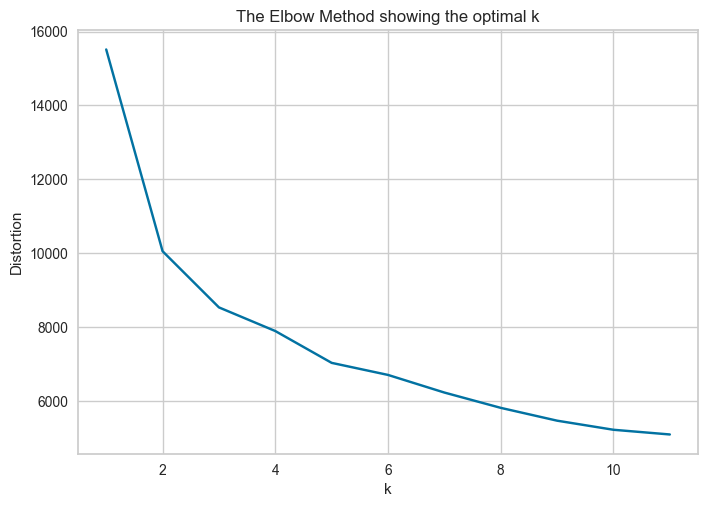

In [12]:
from sklearn.cluster import KMeans

# Elbow Method for distortion
distortions = []
K = range(1, 12)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(df_analysis)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There is also a Silhouette score that helps us define the number of clusters.

The silhouette score interprets and validates the consistency within clusters, which is based on the mean intra-cluster distance and mean nearest-cluster distance for each data point.

The mean intra-cluster distance is the average distance between the data point and all other data points in the same cluster. Essentially, how far each data point is from the centre of its own cluster.

The mean nearest-cluster distance, on the other hand, is the average distance between the data point and all other data points of the next nearest cluster. In other words, how far each data point in 1 cluster is to the centre of its nearest neighbouring cluster.

The silhouette score range is from -1 to +1, where:

"+1" means that a clustered data point is dense and properly separated from other clusters.

A score close to 0 means the clustered data point overlaps with another cluster.

A negative score means that the clustered data point may be wrong; it may even belong to another cluster.

The silhouette score for each data point allows you to build a Silhouette plot, showing each silhouette score for each data point across all clusters.

You can then calculate an average silhouette score for the plot. This average helps to (1) compare different models with a different number of clusters and (2) define a performance metric for a given cluster model. A rule of thumb in the industry is that an average silhouette score greater than 0.5 means the clusters are nicely separated. Still, there may be a case where, for your dataset, the optimal amount of cluster leads to an average lower than 0.5. That is fine also. It just means we computed the optimal way for that dataset to cluster even though it doesn't have a tremendous silhouette score.

To evaluate a cluster's silhouette, we need the data formatted before it hits the model. We have done this already, and the result is stored at df_analysis

We will use SilhouetteVisualizer and KElbowVisualizer from Yellowbrick

The code has the following logic:

First, you will calculate the average silhouette score for different numbers of clusters using KElbowVisualizer() by setting KMeans() as the algorithm, the range 2 to 5 for the number of clusters (it doesn't accept 1 cluster) and the metric='silhouette'. Then you will fit the scaled data (df_analysis) and show the results.

You will evaluate which number of clusters produce the higher average silhouette score.

Then, you will iterate on the silhouette plot for models with a different number of clusters, in this case from 2 to 11. You will use SilhouetteVisualizer() and set the estimator as KMeans(). Then, you will fit the scaled data (df_analysis) and show the results

You will evaluate whether there are clusters with a maximum score below the average score, whether the silhouette values vary too much in the cluster, whether there are too many silhouette values lower than the average silhouette score, and whether there are too many negative silhouette values.

Note the following:

Average Silhouette Score: Two clusters yield the best result, but three is pretty close. We will focus more on evaluating the Silhouette Plot from these options.

Silhouette Plot:

Two clusters: One cluster is dominant (the blue) since it has more observations, and the majority of its values are greater than the average score (the red dotted line). The other cluster (green) has a few data points with a negative score (these may belong to other clusters) and almost no data point is above the average score.

Three clusters: One cluster is dominant (the red) since it has more observations, and the majority of its values are greater than the average score (the red dotted line). The other two clusters look to have a similar frequency. The last blue cluster has a few data points greater than the average and a few with negative silhouette values. However, the green middle cluster has a few data points with a negative score (these may belong to other clusters) and almost no data points are above the average score. This is not as bad as the two clusters since more observations are above the average score in the non-dominant clusters.

=== Average Silhouette Score for different number of clusters ===


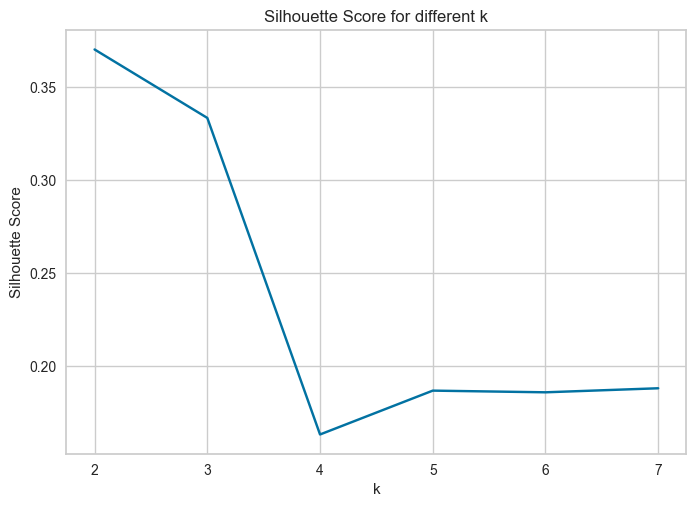



=== Silhouette score for 2 Clusters: 0.370 ===


=== Silhouette score for 3 Clusters: 0.333 ===


=== Silhouette score for 4 Clusters: 0.163 ===


=== Silhouette score for 5 Clusters: 0.187 ===


=== Silhouette score for 6 Clusters: 0.186 ===


=== Silhouette score for 7 Clusters: 0.188 ===


=== Silhouette score for 8 Clusters: 0.161 ===


=== Silhouette score for 9 Clusters: 0.163 ===


=== Silhouette score for 10 Clusters: 0.157 ===




In [16]:
from sklearn.metrics import silhouette_score

print("=== Average Silhouette Score for different number of clusters ===")
silhouette_scores = []
K = range(2, 8)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(df_analysis)
    score = silhouette_score(df_analysis, kmeanModel.labels_)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k')
plt.show()

print("\n")

# For detailed silhouette plots, we can skip or implement manually, but for simplicity, just the scores
for n_clusters in np.arange(start=2, stop=11):
    kmeanModel = KMeans(n_clusters=n_clusters, random_state=0)
    kmeanModel.fit(df_analysis)
    score = silhouette_score(df_analysis, kmeanModel.labels_)
    print(f"=== Silhouette score for {n_clusters} Clusters: {score:.3f} ===")
    print("\n")

What is the number of clusters, then?

The Elbow Method says three.

The average Silhouette Score says two, but the Silhouette Plot from three clusters is better than for two clusters.

Therefore, we will pick three, since the Elbow Method and Silhouette Plot both support that decision.

Next we rewrite the PipelineCluster(), updating n_cluster to 3

Note that you don't necessarily have to rewrite the pipeline in the cell below it in an actual project. You could have scrolled up to the cell where we defined the pipeline previously and updated there. But for learning purposes, we'll rewrite the pipeline in the cell below.

In [14]:
def PipelineCluster():
  pipeline_base = Pipeline([
                            
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                               variables=['mean smoothness']) ),

      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=7, random_state=0)), 

      ("model", KMeans(n_clusters=3, random_state=0)  ),  ##### update n_clusters to 3 
  ])
  return pipeline_base

PipelineCluster()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",7
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True


Notice the additional effort and steps we take in clustering compared to the workflow we have for Classification and Regression. Only now are we ready to train the pipeline.

Note we have only one pipeline, and we are not doing hyperparameter optimisation when training the model.

In the previous sections, we "kind" of optimised hyperparameters since we tried different options for PCA components and the number of clusters for KMeans().

Let's fit the pipeline, then!

## Fit Cluster Pipeline

Rest assured, we make the most of our data resources. There's no need to split our data as we can utilise all available data for training, ensuring a comprehensive approach.

For training purposes, we create a DataFrame X that is a copy of your data.

In [17]:
X = df.copy()
print(X.shape)
X.head(3)

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Then, we fit the Cluster pipeline to the training data (X)

In [18]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",7
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True


## Add cluster predictions to the dataset

We add a column "Clusters" (with the Cluster Pipeline predictions) to X

Scroll to the right and check the last variable. That is the cluster predictions for each data point of your dataset.

The model predictions are stored in an attribute .labels_

Since the model is in the pipeline, you will grab the model using the notation pipeline_cluster['model'].labels_

In [20]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Clusters
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


Next, we are interested to know the cluster frequency.

Note there are three clusters, and the counting starts from 0.

We note that the algorithm found that the majority of the data (63%) belongs to cluster number 2, where the remaining data points are shared equally between the other 2 clusters.

But what is the profile of each cluster?

* Clusters frequencies 
          proportion
Clusters            
2               0.61
1               0.21
0               0.18 




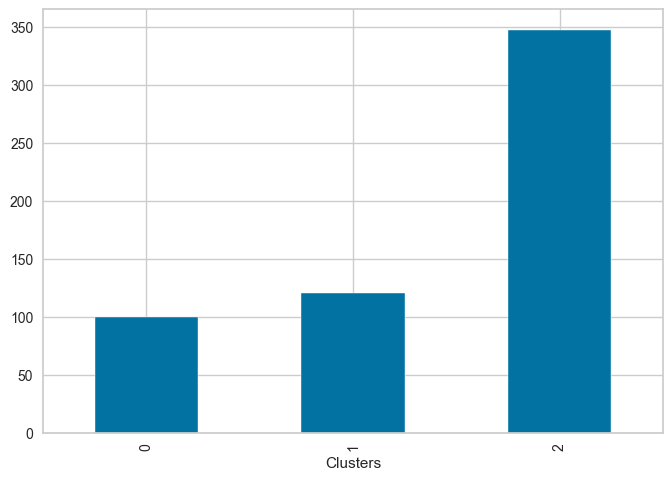

In [21]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Fit a classifier where the target is cluster predictions, and the features are the remaining variables

We are at a point where we have cluster predictions made from the cluster pipeline, but we still need to interpret the clusters.

We are interested in learning each cluster's profile based on the most relevant dataset variables.

Our new dataset has Clusters as a variable. We use a technique where Clusters is the target for a classifier, and the remaining variables will be features for that target.

We will assume that the most relevant features for this classifier, will be the most relevant variables that define a cluster.

To do that, we will use the traditional workflow we covered in the previous notebooks:

1 - split the data into train and test set

2 - create the classifier pipeline

3 - fit the classifier to training data

4 - evaluate pipeline performance

5 - and (most important for our analysis) assess feature importance.

Note: If necessary, pause for a second and reflect on which step from the "Major ideas" section we are in. That may help you better understand our goal, which point we are at, and the next step we move on to.

We initiate the process by duplicating X into a DataFrame df_clf, a step that sets the stage for our subsequent actions.

In [22]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Clusters
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


Next, we split train and test sets, where the target variable is 'Clusters'

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(455, 30) (455,) (114, 30) (114,)


## Create a classifier pipeline

We should use the data cleaning and feature engineering steps from the Cluster Pipeline.

Then we add the conventional steps for supervised learning: feature scaling, feature selection and modelling

We are considering a model that typically offers good results, and feature's importance can be assessed with .features_importance_ using a tree-based algorithm. We are using GradientBoostingClassifier since it typically has good performance while it is fast to train.

We could conduct a detailed hyperparameter optimisation to find the best tree-based model, but we are most interested in finding a pipeline that can explain the relationship between the target (Clusters) and the features to assess the feature's importance afterwards.

In [25]:
### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithm
from sklearn.ensemble import GradientBoostingClassifier 

def PipelineClf2ExplainClusters():
  pipeline_base = Pipeline([
                            
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                               variables=['mean smoothness']) ),

      ("scaler", StandardScaler()  ),    

      ("feat_selection", SelectFromModel(GradientBoostingClassifier(random_state=0)) ), 

      ("model",  GradientBoostingClassifier(random_state=0) ), 
  ])
  return pipeline_base

  

PipelineClf2ExplainClusters()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"estimator estimator: objectThe base estimator from which the transformer is built.This can be both a fitted (if ``prefit`` is set to True)or a non-fitted estimator. The estimator should have a``feature_importances_`` or ``coef_`` attribute after fitting.Otherwise, the ``importance_getter`` parameter should be used.",GradientBoost...andom_state=0)
,"threshold threshold: str or float, default=NoneThe threshold value to use for feature selection. Features whoseabsolute importance value is greater or equal are kept while the othersare discarded. If ""median"" (resp. ""mean""), then the ``threshold`` valueis the median (resp. the mean) of the feature importances. A scalingfactor (e.g., ""1.25*mean"") may also be used. If None and if theestimator has a parameter penalty set to l1, either explicitlyor implicitly (e.g, Lasso), the threshold used is 1e-5.Otherwise, ""mean"" is used by default.",None


We fit the classifier to the training data

Note again, here we are not doing a detailed hyperparameter optimisation. This classification pipeline is useful only for the the features that look to be more important to predict the Clusters. We are not deploying this model, so fitting with the default hyperparameters is fine for this task.

In [26]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"estimator estimator: objectThe base estimator from which the transformer is built.This can be both a fitted (if ``prefit`` is set to True)or a non-fitted estimator. The estimator should have a``feature_importances_`` or ``coef_`` attribute after fitting.Otherwise, the ``importance_getter`` parameter should be used.",GradientBoost...andom_state=0)
,"threshold threshold: str or float, default=NoneThe threshold value to use for feature selection. Features whoseabsolute importance value is greater or equal are kept while the othersare discarded. If ""median"" (resp. ""mean""), then the ``threshold`` valueis the median (resp. the mean) of the feature importances. A scalingfactor (e.g., ""1.25*mean"") may also be used. If None and if theestimator has a parameter penalty set to l1, either explicitlyor implicitly (e.g, Lasso), the threshold used is 1e-5.Otherwise, ""mean"" is used by default.",None


## Evaluate the classifier performance on the Train and Test Sets

In theory, we expect to have a good performance, since the Clusters were generated by the KMeans() and that algorithm has a logic. As a result, the classifier algorithm (GradientBoosting) would be able to map these relationships, in theory. So let's check that.

Then evaluate the performance on the Train set using classification_report()

It looks to have learned the relationships to ace all predictions in the train set.

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00       284

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



And finally, we evaluate in the test set.

It looks to have learned the relationship between the target and the features to generalise on the test set, since the performance is not much different from the train set.

In [28]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.96      1.00      0.98        26
           2       0.98      1.00      0.99        64

    accuracy                           0.98       114
   macro avg       0.98      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114



## Assess the Most Important Features that define a cluster

Now we assess the feature importance from the pipeline. First, we need to know how many data cleaning and feature engineering steps your pipeline has.

It has one step only: median imputation.

In [29]:
pipeline_clf_cluster

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('MeanMedianImputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,imputation_method,'median'
,variables,['mean smoothness']
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"estimator estimator: objectThe base estimator from which the transformer is built.This can be both a fitted (if ``prefit`` is set to True)or a non-fitted estimator. The estimator should have a``feature_importances_`` or ``coef_`` attribute after fitting.Otherwise, the ``importance_getter`` parameter should be used.",GradientBoost...andom_state=0)
,"threshold threshold: str or float, default=NoneThe threshold value to use for feature selection. Features whoseabsolute importance value is greater or equal are kept while the othersare discarded. If ""median"" (resp. ""mean""), then the ``threshold`` valueis the median (resp. the mean) of the feature importances. A scalingfactor (e.g., ""1.25*mean"") may also be used. If None and if theestimator has a parameter penalty set to l1, either explicitlyor implicitly (e.g, Lasso), the threshold used is 1e-5.Otherwise, ""mean"" is used by default.",None


We use the same code we saw in the previous unit notebook where we grab the feature importance from the feature selection step and store it in a DataFrame.

The plot shows that these are the 4 most important features in descending order: ['mean concavity', 'worst perimeter', 'worst fractal dimension', 'mean perimeter']

We are considering these as the most important variables that define a Cluster. They will be used to understand the Cluster Profile

* These are the 4 most important features in descending order. The model was trained on them: 
['mean concavity', 'worst perimeter', 'worst fractal dimension', 'area error'] 



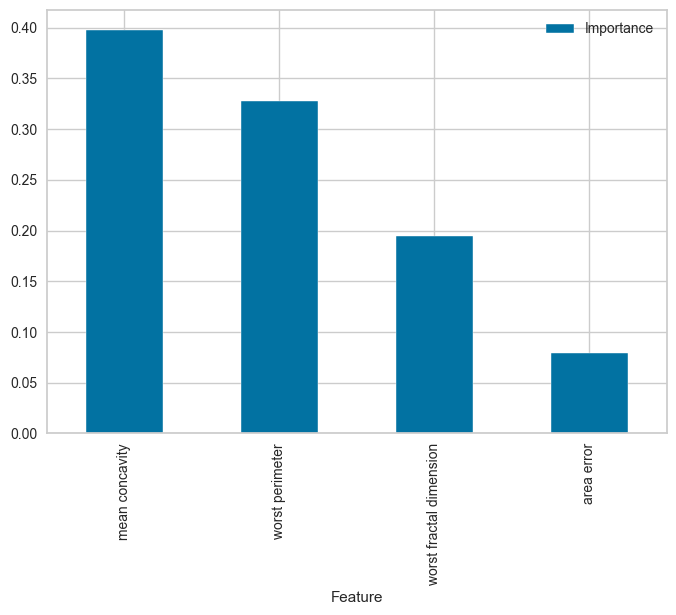

In [30]:
# after data cleaning and feat engineering, the feature space changes

data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering steps does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
          'Importance': pipeline_clf_cluster['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Feature'].to_list() # reassign best features in importance order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Cluster Analysis

Bravo! You know which variables to consider now to explain each cluster!

Let's create a custom function where we will explain the cluster profile, in terms of ['mean concavity', 'worst perimeter', 'worst fractal dimension', 'mean perimeter']. For each cluster, we want to know the most common values for each variable.

Go through the code and check the pseudo-code and comments to understand its logic. It may take a while to understand it all, but the focus is to understand and apply the function to our business problem.

In [43]:
# df contains the most important features and the clusters
# Note: your DataFrame needs to have a variable called 'Clusters' which will
# contain the cluster prediction from the pipeline

# It outputs a table showing for each cluster what is the most common values for a given variable

def DescriptionAllClusters(df, decimal_points=3):

  result_df = pd.DataFrame(columns=df.drop(['Clusters'],axis=1).columns)
  # iterate on each cluster , calls Clusters_IndividualDescription()
  for cluster in df.sort_values(by='Clusters')['Clusters'].unique():
    
      EDA_ClusterSubset = df.query(f"Clusters == {cluster}").drop(['Clusters'],axis=1)
      ClusterDescription = Clusters_IndividualDescription(EDA_ClusterSubset,cluster,decimal_points)
      result_df = pd.concat([result_df, ClusterDescription], ignore_index=True)

  

  result_df.set_index(['Cluster'],inplace=True)
  return result_df

def Clusters_IndividualDescription(EDA_Cluster,cluster, decimal_points):

  ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
  # for a given cluster, iterate in all columns
  # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
  # if the variable is categorical, count the frequencies and display the top 3 most frequent
    # That will show the most common levels for the category

  for col in EDA_Cluster.columns:
    
    try:  # eventually a given cluster will have only missing data for a given variable
      
      if EDA_Cluster[col].dtypes == 'object':
        
        top_frequencies = EDA_Cluster.dropna(subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
        Description = ''
        
        for x in range(len(top_frequencies)):
          freq = top_frequencies.iloc[x]
          category = top_frequencies.index[x][0]
          CategoryPercentage = int(round(freq*100,0))
          statement =  f"'{category}': {CategoryPercentage}% , "  
          Description = Description + statement
        
        ClustersDescription.at[0,col] = Description[:-2]

      elif EDA_Cluster[col].dtypes in ['float', 'int']:
        DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
        Q1 = round(DescStats.iloc[4,0], decimal_points)
        Q3 = round(DescStats.iloc[6,0], decimal_points)
        Description = f"{Q1} -- {Q3}"
        ClustersDescription.at[0,col] = Description
    
    
    except Exception as e:
      ClustersDescription.at[0,col] = 'Not available'
      print(f"** Error Exception: {e} - cluster {cluster}, variable {col}")
  
  ClustersDescription['Cluster'] = str(cluster)
  
  return ClustersDescription

The next custom function is called cluster_distribution_per_variable() and is used to analyse the Clusters and given Variable - in our case, it will evaluate Clusters x Diagnostic.

It will show the absolute and relative levels of Diagnostic (Malignant and Benign) per cluster
Go through the code and check the pseudo-code and comments to understand its logic. It may take a while to understand it all, but the focus is to understand and apply the function to our business problem.

In [36]:
import plotly.express as px
def cluster_distribution_per_variable(df,target):

  # the data should have 2 variables, the cluster predictions and
  # the variable you want to analyze with, in this case we call "target"
  
  # we use plotly express to create 2 plots
  # cluster distribution across the target
  # relative presence of the target level in each cluster
   
  df_bar_plot = df.value_counts(["Clusters", target]).reset_index() 
  df_bar_plot.columns = ['Clusters',target,'Count']
  df_bar_plot[target] = df_bar_plot[target].astype('object')

  print(f"Clusters distribution across {target} levels")
  fig = px.bar(df_bar_plot, x='Clusters',y='Count',color=target,width=800, height=500)
  fig.update_layout(xaxis=dict(tickmode= 'array',tickvals= df['Clusters'].unique()))
  fig.show()

  df_relative = (df
                 .groupby(["Clusters", target])
                 .size()
                 .groupby(level=0)
                 .apply(lambda x:  100*x / x.sum())
                 .reset_index()
                 .sort_values(by=['Clusters'])
                 )
  df_relative.columns = ['Clusters',target,'Relative Percentage (%)']
 
  print(f"Relative Percentage (%) of {target} in each cluster")
  fig = px.line(df_relative, x='Clusters',y='Relative Percentage (%)',color=target,width=800, height=500)
  fig.update_traces(mode='markers+lines')
  fig.show()

To start the analysis we want a DataFrame that contains the best features and Cluster Predictions since we want to analyse the patterns for each cluster.

We will copy df_clf DataFrame (since it has all the features and Cluster predictions) and filter best_features plus ['Clusters'].

In [37]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(569, 5)


,mean concavity,worst perimeter,worst fractal dimension,area error,Clusters
0,0.3001,184.6,0.11890,153.40,1
1,0.0869,158.8,0.08902,74.08,1
2,0.1974,152.5,0.08758,94.03,1


We want also to analyse Diagnostic levels

In this exercise, we get it from data.target and create a DataFrame.

We know in advance Diagnostic represents a categorical variable and came as an integer. Therefore we change its data type to 'object'.

In [38]:
df_diagnostic = pd.DataFrame(data.target, columns=['diagnostic'])
df_diagnostic['diagnostic'] = df_diagnostic['diagnostic'].astype('object')
df_diagnostic.head(3)

,diagnostic
0,0
1,0
2,0


## Cluster profile on most important features

We call DescriptionAllClusters() and parse a concatenated DataFrame made with df_cluster_profile and df_diagnostic. Before parsing let's just show this concatenated data so you can visualise it better.

It has the best features ['mean concavity', 'worst perimeter', 'worst fractal dimension', 'mean perimeter'], Cluster Predictions and Diagnostic (where 0 is malignant, 1 is benign)

In [39]:
pd.concat([df_cluster_profile,df_diagnostic], axis=1).head(4)

,mean concavity,worst perimeter,worst fractal dimension,area error,Clusters,diagnostic
0,0.3001,184.60,0.11890,153.40,1,0
1,0.0869,158.80,0.08902,74.08,1,0
2,0.1974,152.50,0.08758,94.03,1,0
3,0.2414,98.87,0.17300,27.23,0,0


Finally, we use DescriptionAllClusters() parsing the concatenated DataFrame. It outputs a table showing for each cluster what are the most common values for a given variable, including the diagnostic level (where 0 is malignant, 1 is benign). You will also parse the decimal points you want to display when the evaluated variable is numerical; depending on the range of the numerical variable, you may need more decimal points. In our case, 2 decimal points are fine, but you can re-run the function after and check with different values, like 0 and 4.

Recall that we found the most important variables that help to define a cluster are: ['mean concavity', 'worst perimeter', 'worst fractal dimension', 'mean perimeter']

Note that the algorithm found that for Cluster 0, the most common values for mean concavity are between 0.13 -- 0.22, for worst perimeter, is between 145.7 -- 174.18, worst fractal is between 0.08 -- 0.09 and mean perimeter is between 120.88 -- 136.88. Also, all diagnoses in cluster 0 are 0 - malignant. This is the profile from cluster 0!

Repeat this analysis for the remaining clusters. Note we start giving meaning to each cluster.

Note also our analysed variable (diagnostic). It shows that cluster 0 has only malignant cases, cluster 1 is a mix between malignant and benign, but malignant is more dominant, and cluster only has two benign cases.

Think for a moment about how cool that is. The algorithm found patterns to split into three groups, one with malignant, another a mix and the last benign. Now think how this analysis could be applied to solve other business problems.

Note the major differences/patterns between clusters across variables, like:

The ranges of mean concavity look to be smaller when the diagnostic is benign (1) and look to increase when diagnostic tends to 0 (malignant).

The values of the worst perimeter in clusters where malignant is predominant tend to be higher than in benign clusters.

Note we keep adding meaning to how the clusters interact based on the analysis between a given variable (mean concavity, for example) and diagnostic

Repeat the same analysis for other variables (worst fractal and mean perimeter)

Typically you will notice differences in ranges across the clusters and across the levels of your analyzed variable (diagnostic). This difference is typically the pattern we are interested to discover.

In [45]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_diagnostic], axis=1),
                                          decimal_points=2)
clusters_profile

,mean concavity,worst perimeter,worst fractal dimension,area error,diagnostic
Cluster,,,,,
0,0.1 -- 0.18,91.36 -- 119.5,0.09 -- 0.12,20.9 -- 40.32,"'0': 60% , '1': 40%"
1,0.13 -- 0.22,143.4 -- 171.1,0.08 -- 0.09,67.66 -- 112.4,'0': 100%
2,0.02 -- 0.05,79.8 -- 98.93,0.07 -- 0.08,15.45 -- 26.44,"'1': 91% , '0': 9%"


## Clusters distribution across Diagnostic levels & Relative Percentage of Diagnostic in each cluster

This analysis shows the Cluster's distribution across Diagnostic. This information is revealed in the previous table, but now we can make it more visual to stakeholders. It has 2 plots:

The first is a bar plot, in the x-axis the clusters, the bar length is how many data points are in that cluster and is coloured by the level of diagnosis (where 0 is malignant, 1 is benign).

The second plot gives a complementary vision to the first. In the first, we saw the absolute values (the counts). Now we see the relative (the percentage).

Let's analyse the plots

The first plot shows that cluster 0 has malignant cases only. Cluster 1 a mix of both cases with malignant predominant. The last cluster is predominantly benign cases (however, there are few malignant cases. If required, you could do a data analysis later on these malignant cases.)

The second plot reveals the percentage presence of Diagnostic (malignant and benign) and displays the percentage in each cluster.

In [46]:
df_cluster_vs_diagnostic=  df_diagnostic.copy()
df_cluster_vs_diagnostic['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_diagnostic, target='diagnostic')

Clusters distribution across diagnostic levels


ValueError: cannot insert Clusters, already exists

## What should I do now?

You could deploy the Cluster Pipeline as is. However, it would need all 30 variables to predict a given cluster for a new breast sample even though you used 4 variables to describe the profile from each cluster.

In a real system, we should consider the number of input variables we want to manage.

Therefore, we would consider an additional step for trying to refit the cluster pipeline using the most important variables. We say "trying" since we will need to conduct a tradeoff analysis to validate if the pipeline with all variables and the pipeline with only the "best feature" produce "equivalent" results.

In case they produce "equivalent" results, you can deploy a pipeline with fewer variables that will deliver a similar performance.

For the moment, what really matters is to understand that we can cluster the data on similar data points, explain the profile of clusters, and we can analyse the clusters vs another variable (in our case, clusters vs diagnostic)